# Набор данных о кино-индустрии
- Предметная область: Индустрия кино. Анализ финансовых показателей проката, популярности жанров, прогнозирование доходов
- Источник: https://www.kaggle.com/datasets/danielgrijalvas/movies
- Тип данных: Реальные данные 7000+ фильмов за 1986-2020 года с ресурса IMDb

Набор применим для:
- Регрессии: Прогнозирования доходности проката фильма на основе доступных данных
- Кластеризация: по бюджету и дохода фильма, по рейтингу

Признаки:

| Тип данных | Признак | Описание                     |
|------------|---------|------------------------------|
| name       | string  | Название фильма              |
| rating     | string  | Возрастной рейтинг           |
| genre      | string  | Жанр                         |
| year       | int64   | Год выпуска                  |
| released   | string  | Дата и место первого проката |
| score      | float64 | Рейтинг IMDb                 |
| votes      | float64 | Количество голосов           |
| director   | string  | Режиссёр                     |
| writer     | string  | Сценарист                    |
| star       | string  | Главный актёр                |
| country    | string  | Страна                       |
| budget     | float64 | Бюджет                       |
| gross      | float64 | Доход                        |
| company    | string  | Продюсер                     |
| runtime    | float64 | Продолжительность в минутах  |

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
from typing import Optional

In [69]:
df = pd.read_csv('raw/movies/movies.csv')
df.drop('released', axis=1)
df.sample(10, random_state=228)

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
2494,North,PG,Adventure,1994,"July 22, 1994 (United States)",4.5,13000.0,Rob Reiner,Alan Zweibel,Elijah Wood,United States,40000000.0,7182747.0,Castle Rock Entertainment,87.0
4126,The Good Girl,R,Drama,2002,"August 30, 2002 (United States)",6.4,44000.0,Miguel Arteta,Mike White,Jennifer Aniston,United States,8000000.0,16860964.0,Flan de Coco Films,93.0
5649,Kick-Ass,R,Action,2010,"April 16, 2010 (United States)",7.6,535000.0,Matthew Vaughn,Jane Goldman,Aaron Taylor-Johnson,United Kingdom,30000000.0,96188903.0,Marv Films,117.0
3382,Dead Man on Campus,R,Comedy,1998,"August 21, 1998 (United States)",6.0,14000.0,Alan Cohn,Anthony Abrams,Tom Everett Scott,United States,14000000.0,15064946.0,Paramount Pictures,96.0
1573,Tap,PG-13,Comedy,1989,"February 10, 1989 (United States)",6.5,1500.0,Nick Castle,Nick Castle,Gregory Hines,United States,NaN,9114702.0,Beco Films,111.0
7486,Anna,R,Action,2019,"June 21, 2019 (United States)",6.6,69000.0,Luc Besson,Luc Besson,Sasha Luss,France,NaN,31626978.0,Summit Entertainment,118.0
4640,Clifford's Really Big Movie,G,Animation,2004,"April 23, 2004 (United States)",5.4,822.0,Robert C. Ramirez,Rhett Reese,John Ritter,United States,70000.0,3255426.0,Big Red Dog Productions,74.0
2690,While You Were Sleeping,PG,Comedy,1995,"April 21, 1995 (United States)",6.7,95000.0,Jon Turteltaub,Daniel G. Sullivan,Sandra Bullock,United States,17000000.0,182057016.0,Hollywood Pictures,103.0
5337,Miss Pettigrew Lives for a Day,PG-13,Comedy,2008,"March 7, 2008 (United States)",7.1,27000.0,Bharat Nalluri,David Magee,Frances McDormand,United Kingdom,NaN,16724933.0,Focus Features,92.0
932,Lady Jane,PG-13,Biography,1986,"February 7, 1986 (United States)",7.1,6300.0,Trevor Nunn,Chris Bryant,Helena Bonham Carter,United Kingdom,8500000.0,277646.0,Capital Equipment Leasing,136.0


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7668 entries, 0 to 7667
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      7668 non-null   object 
 1   rating    7591 non-null   object 
 2   genre     7668 non-null   object 
 3   year      7668 non-null   int64  
 4   released  7666 non-null   object 
 5   score     7665 non-null   float64
 6   votes     7665 non-null   float64
 7   director  7668 non-null   object 
 8   writer    7665 non-null   object 
 9   star      7667 non-null   object 
 10  country   7665 non-null   object 
 11  budget    5497 non-null   float64
 12  gross     7479 non-null   float64
 13  company   7651 non-null   object 
 14  runtime   7664 non-null   float64
dtypes: float64(5), int64(1), object(9)
memory usage: 898.7+ KB


Видно, что многие целочисленные признаки считались как вещественные. Поправим это

In [71]:
# Convert real values to integers if necessary.
float_features = df.select_dtypes(include='float64').columns
float_features = float_features.dropna()
for feature in float_features:
    func = lambda el: pd.isna(el) or (pd.notna(el) and el.is_integer())
    if df[feature].apply(func).all():
        df[feature] = df[feature].astype('Int64')

Год выпуска (year) часто не совпадает с годом первого показа из released, хотя последний является более важным признаком.

Заменим значения year на год из released, если возможно, а released можно будет удалить

In [72]:
regex = r'(\w+) (\d+), (\d+) \((.+)\)'
for value in df['released']:
    if not re.match(regex, str(value)):
        print(value)

df[df['released'].isna()]

November 1980 (United Kingdom)
1981 (United States)
1982 (Japan)
October 1982 (United States)
March 1992 (United States)
January 1983 (United Kingdom)
August 1983 (United States)
February 1984 (United States)
March 1985 (United States)
September 1987 (United States)
March 1986 (United States)
1985 (Taiwan)
1985 (United States)
October 1986 (United States)
February 1987 (United States)
April 1986 (United States)
1987 (United States)
May 1988 (United Kingdom)
September 1987 (United States)
June 1991 (United States)
May 1989 (United States)
May 1988 (United States)
August 1988 (United States)
October 1988 (United States)
October 1988 (United States)
June 1988 (United States)
March 1989 (United States)
July 1989 (United States)
June 1990 (United States)
April 1990 (United States)
May 1990 (United States)
April 1991 (United States)
April 1991 (United States)
December 1991 (United States)
March 1991 (United States)
April 1991 (United States)
January 1991 (United States)
August 1991 (United S

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
5728,Saw: The Final Chapter,R,Crime,2010,NaN,5.6,93000,Kevin Greutert,Patrick Melton,Tobin Bell,NaN,<NA>,<NA>,NaN,<NA>
5730,The Wolfman,R,Drama,2010,NaN,5.8,104000,Joe Johnston,Andrew Kevin Walker,Benicio Del Toro,NaN,<NA>,<NA>,NaN,<NA>


Имеем значения вида '...{year} ({country})' и два вхождения с NaN, которые вскоре всё равно будут удалены, ведь по ним слишком мало информации

In [73]:
def released_to_year(val_str: str) -> Optional[int]:
    val_str = val_str.split('(')[0].strip()
    return int(val_str[-4:])


func = lambda el: released_to_year(el['released']) if str(el['released']) != 'nan' else el['year']
df['year'] = df.apply(func, axis=1)
df = df.drop('released', axis=1)

In [74]:
# Show how many NaN values are in the table.
columns = df.columns
total_rows = df.shape[0]
no_misses_rows = []
for col in columns:
    nan_count = df[col].isna().sum()
    not_empty = df[col].count()
    if not_empty == total_rows:
        no_misses_rows.append(col)
    else:
        print(f'{col}: NaN={nan_count}, Values={not_empty} of {total_rows} rows')
print(f'Cols without any NaN/Empty: {", ".join(no_misses_rows)}')

rating: NaN=77, Values=7591 of 7668 rows
score: NaN=3, Values=7665 of 7668 rows
votes: NaN=3, Values=7665 of 7668 rows
writer: NaN=3, Values=7665 of 7668 rows
star: NaN=1, Values=7667 of 7668 rows
country: NaN=3, Values=7665 of 7668 rows
budget: NaN=2171, Values=5497 of 7668 rows
gross: NaN=189, Values=7479 of 7668 rows
company: NaN=17, Values=7651 of 7668 rows
runtime: NaN=4, Values=7664 of 7668 rows
Cols without any NaN/Empty: name, genre, year, director


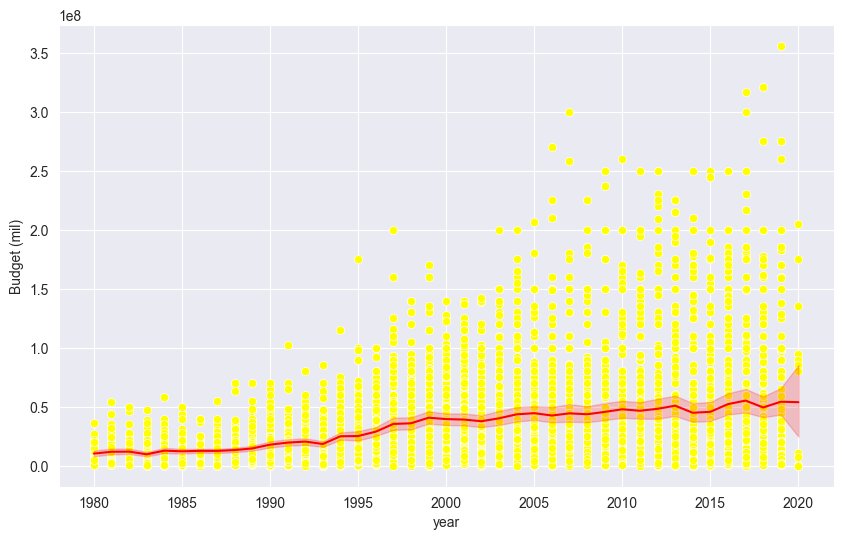

In [75]:
# Show distribution between budget & year.
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='year', y='budget', color='yellow')
sns.lineplot(data=df, x='year', y='budget', color='red')
plt.ylabel('Budget (mil)')
plt.show()

С годами бюджет фильмов растёт. Попробуем заменить NaN на медианные значения бюджета, опираясь на годовые показатели

In [76]:
# Replace budget NaN values.
mean_per_year = df.groupby('year')['budget'].transform('mean').astype('Int64')
df['budget'] = df['budget'].fillna(mean_per_year)
print('NaN values left:', df.isna().sum().sum())
df.isna().sum().sort_values(ascending=False)

NaN values left: 300


gross       189
rating       77
company      17
runtime       4
score         3
votes         3
writer        3
country       3
star          1
name          0
genre         0
year          0
director      0
budget        0
dtype: int64

Записи с неопределенными показателями дохода можно удалить за ненадобностью, останется относительно мало включений с NaN - их тоже можно удалить

In [77]:
df = df.dropna()
print('NaN values left:', df.isna().sum().sum())

NaN values left: 0


### Анализ и визуализация

In [78]:
df.sample(10)

,name,rating,genre,year,score,votes,director,writer,star,country,budget,gross,company,runtime
295,The Soldier,R,Action,1982,5.3,1100,James Glickenhaus,James Glickenhaus,Ken Wahl,United States,4000000,6328816,James Glickenhaus,96
7113,The Mummy,PG-13,Action,2017,5.4,177000,Alex Kurtzman,David Koepp,Tom Cruise,United States,125000000,409231607,Universal Pictures,110
6661,Terminator Genisys,PG-13,Action,2015,6.3,264000,Alan Taylor,Laeta Kalogridis,Arnold Schwarzenegger,United States,155000000,440603537,Paramount Pictures,126
990,Wisdom,R,Crime,1987,5.7,3100,Emilio Estevez,Emilio Estevez,Emilio Estevez,United States,12575437,5715174,Gladden Entertainment,109
3334,The Replacement Killers,R,Action,1998,6.2,28000,Antoine Fuqua,Ken Sanzel,Chow Yun-Fat,United States,30000000,19204929,Columbia Pictures,87
94,An American Werewolf in London,R,Comedy,1981,7.5,97000,John Landis,John Landis,David Naughton,United Kingdom,10000000,30669378,Polygram Pictures,97
4596,Black Friday,Not Rated,Action,2007,8.5,20000,Anurag Kashyap,Anurag Kashyap,Kay Kay Menon,India,44402981,1610897,Mid Day Multimedia Limited,143
5271,The Reader,R,Drama,2009,7.6,234000,Stephen Daldry,David Hare,Kate Winslet,Germany,32000000,108902486,The Weinstein Company,124
4517,The Perfect Score,PG-13,Comedy,2004,5.7,24000,Brian Robbins,Marc Hyman,Scarlett Johansson,United States,40000000,10898337,Paramount Pictures,93
5986,Hobo with a Shotgun,Not Rated,Action,2011,6.1,45000,Jason Eisener,John Davies,Rutger Hauer,Canada,3000000,748453,Rhombus Media,86


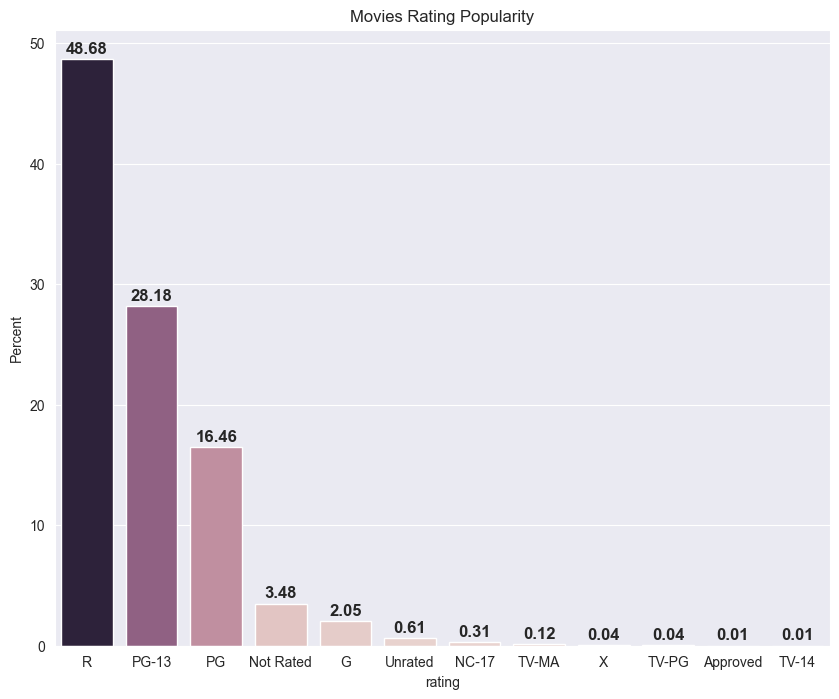

In [79]:
# G - General Audiences (no restrictions);
# PG - Parental Guidance Suggested;
# PG-13 - 13+;
# R - 17+;
# NC-17 - 18+.

data = df['rating'].value_counts()
data = round(data / sum(data) * 100, 2)

plt.figure(figsize=(10, 8))
ax = sns.barplot(
    x=data.index, y=data,
    hue=data, legend=False
)
plt.ylabel('Percent')
plt.title(f'Movies Rating Popularity')
for ind, val in enumerate(data):
    ax.annotate(
        f'{val:.2f}', xy=(ind, val+0.5), ha='center',
        fontsize=12, fontweight='bold'
    )

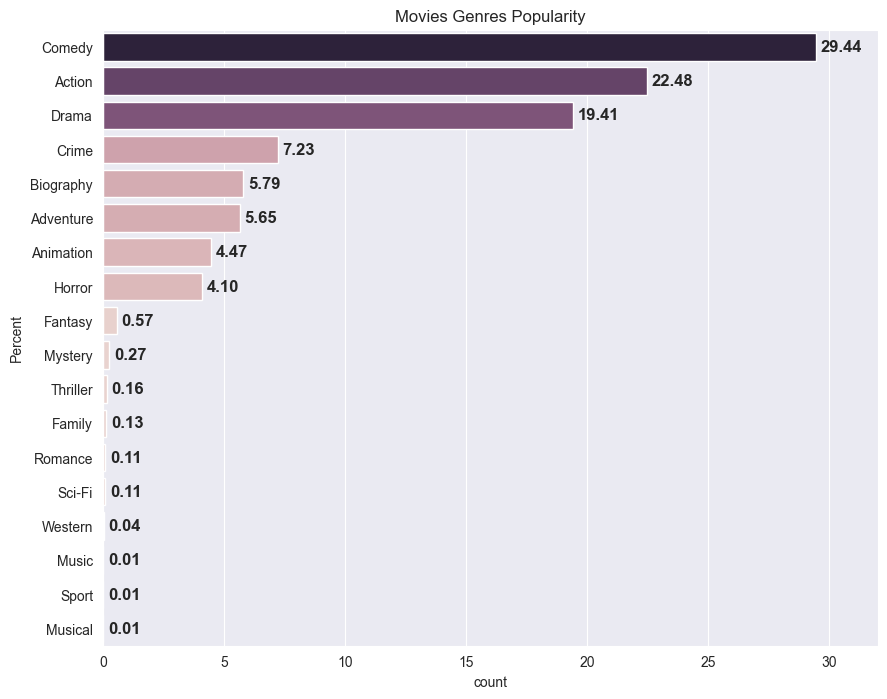

In [80]:
data = df['genre'].value_counts()
data = round(data / sum(data) * 100, 2)

plt.figure(figsize=(10, 8))
ax = sns.barplot(
    x=data,
    y=data.index,
    hue=data,
    legend=False
)
ax.set_xlim(0, 32)
plt.ylabel('Percent')
plt.title('Movies Genres Popularity')
for i, value in enumerate(data):
    ax.annotate(
        f'{value:.2f}', xy=(value+0.2, i), va='center',
        fontsize=12, fontweight='bold'
    )

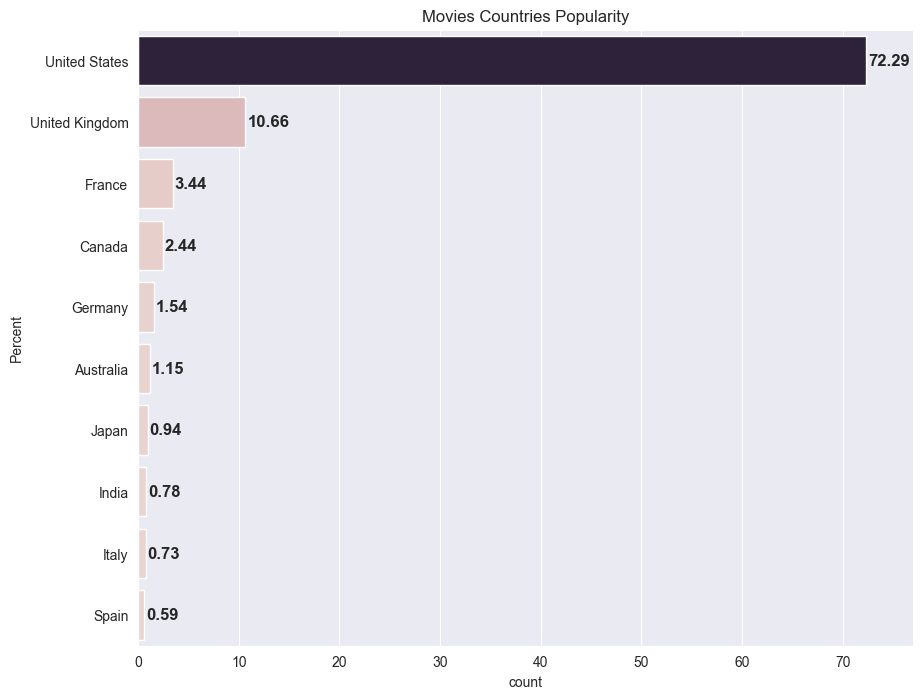

In [81]:
data = df['country'].value_counts()
data = round(data / sum(data) * 100, 2)
data = data[:10]

plt.figure(figsize=(10, 8))
ax = sns.barplot(
    x=data,
    y=data.index,
    hue=data,
    legend=False
)
ax.set_xlim(0, 77)
plt.ylabel('Percent')
plt.title('Movies Countries Popularity')
for i, value in enumerate(data):
    ax.annotate(
        f'{value:.2f}', xy=(value+0.2, i), va='center',
        fontsize=12, fontweight='bold'
    )

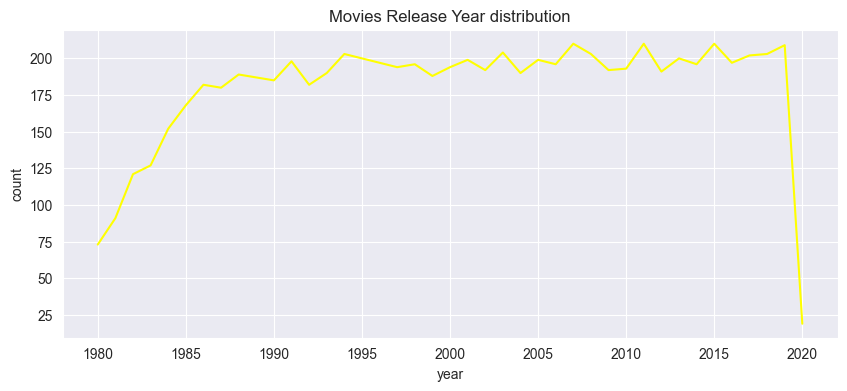

In [82]:
data = df['year'].value_counts()

plt.figure(figsize=(10, 4))
ax = sns.lineplot(x=data.index, y=data, color='yellow')
plt.title('Movies Release Year distribution')
plt.show()

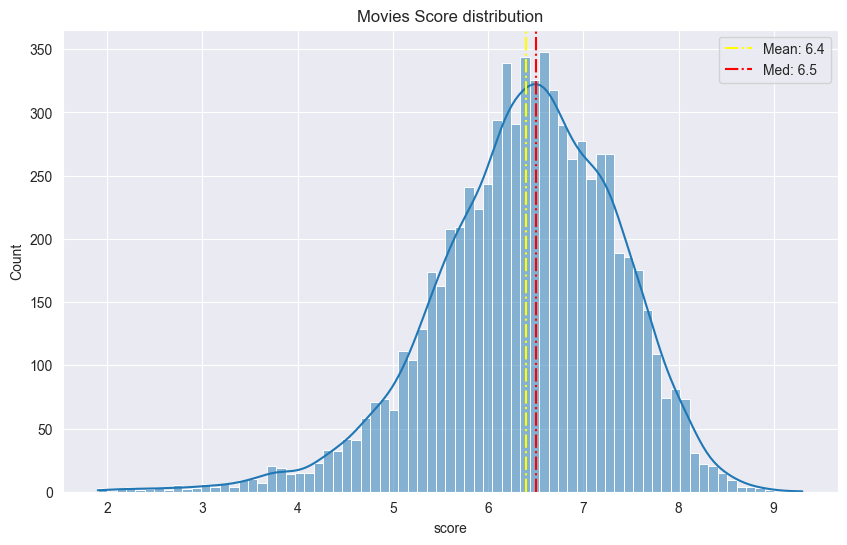

The score data skew: -0.61


In [83]:
data = df['score']

plt.figure(figsize=(10, 6))
plt.title('Movies Score distribution')

# Histogram.
bins = 10 * (data.max() - data.min()) + 1
sns.histplot(data, kde=True, bins=int(bins))

# Median and Mean lines.
mean, med = data.mean(), data.median()
plt.axvline(mean, color='yellow', linestyle='-.', label=f'Mean: {mean:.1f}')
plt.axvline(med, color='red', linestyle='-.', label=f'Med: {med:.1f}')

plt.legend()
plt.show()

print(f'The score data skew: {df["score"].skew(): 0.2f}')

In [84]:
def print_top(df_col: pd.Series, param: str, cnt: int = 5) -> None:
    print(f'Top {cnt} {param} by number of movies')
    for k, v in df_col.value_counts().head(cnt).items():
        print(f'\t{k}: {v}')
    print()

print_top(df['director'], 'directors')
print_top(df['writer'], 'writers')
print_top(df['company'], 'companies')

Top 5 directors by number of movies
	Woody Allen: 38
	Clint Eastwood: 31
	Steven Spielberg: 27
	Directors: 25
	Ron Howard: 24

Top 5 writers by number of movies
	Woody Allen: 37
	Stephen King: 31
	Luc Besson: 25
	John Hughes: 25
	William Shakespeare: 15

Top 5 companies by number of movies
	Universal Pictures: 376
	Warner Bros.: 332
	Columbia Pictures: 332
	Paramount Pictures: 319
	Twentieth Century Fox: 240



In [85]:
print('Top 15 movies of all time (by IMDb rating)')
filtered = df['score'].nlargest(15)
df.loc[filtered.index, ['year', 'name', 'score']]

Top 15 movies of all time (by IMDb rating)


,year,name,score
2443,1994,The Shawshank Redemption,9.3
5243,2008,The Dark Knight,9.0
2247,1994,Schindler's List,8.9
2444,1994,Pulp Fiction,8.9
4245,2003,The Lord of the Rings: The Return of the King,8.9
2445,1994,Forrest Gump,8.8
3444,1999,Fight Club,8.8
3845,2001,The Lord of the Rings: The Fellowship of the Ring,8.8
5643,2010,Inception,8.8
2,1980,Star Wars: Episode V - The Empire Strikes Back,8.7


### Зависимости признаков. Матрица корреляции.

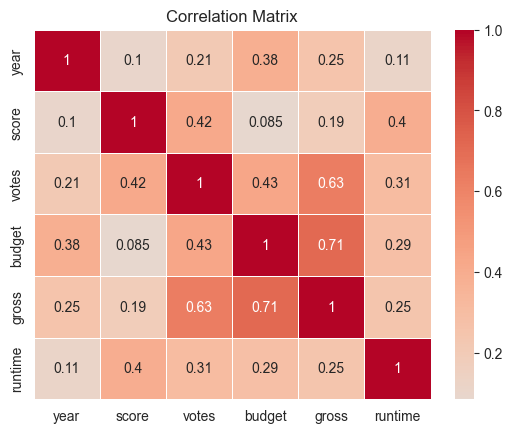

In [86]:
df_numeric = df.select_dtypes(include=[np.number])
corr_matrix = df_numeric.corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

Из матрицы видно:
1. Сильную положительную зависимость gross от budget = 0.71
2. Сильную положительную зависимость gross от votes  = 0.63

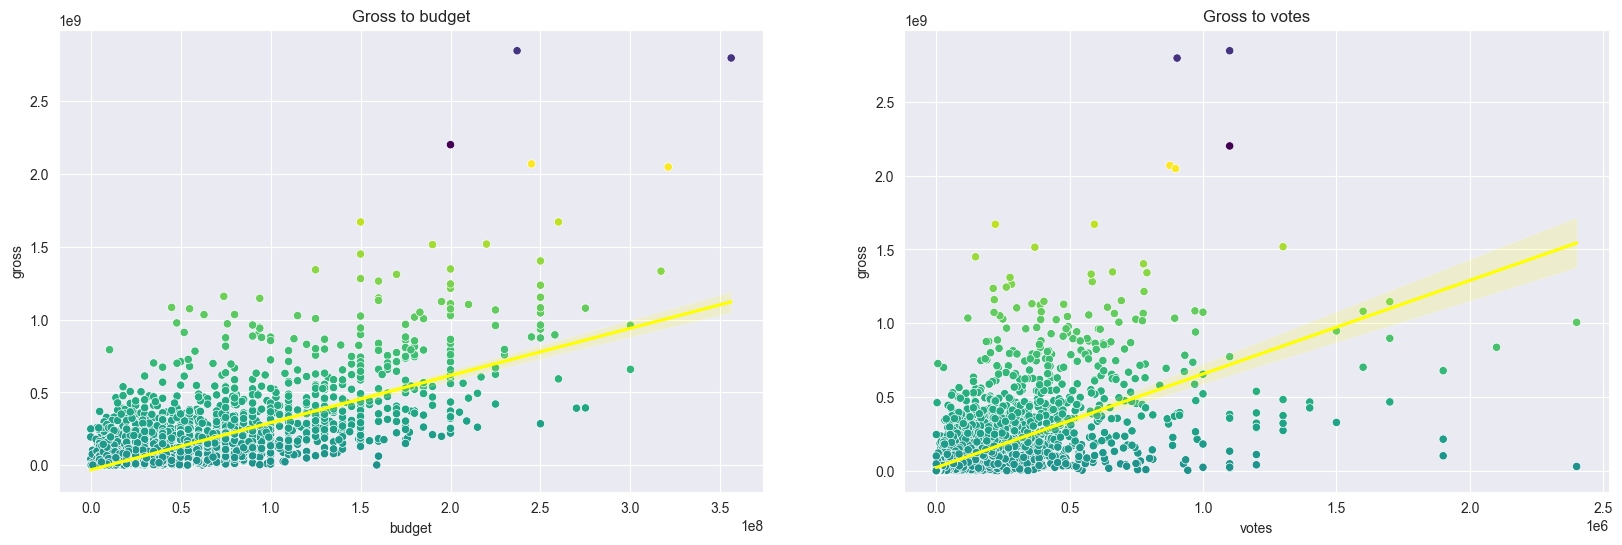

In [87]:
plt.figure(figsize=(20, 6))

# Plot 1: Gross/Budget.
plt.subplot(1, 2, 1)
sns.scatterplot(x='budget', y='gross', data=df, hue=df['gross'].astype(int), legend=False, palette='viridis')
sns.regplot(x='budget', y='gross', data=df, scatter=False, color='yellow')
plt.title('Gross to budget')

# Plot 2: Gross/Votes.
plt.subplot(1, 2, 2)
sns.scatterplot(x='votes', y='gross', data=df, hue=df['gross'].astype(int), legend=False, palette='viridis')
sns.regplot(x='votes', y='gross', data=df, scatter=False, color='yellow')
plt.title('Gross to votes')

plt.show()

Выводы:
1. Чем сильнее растёт бюджет, тем больше доход;
2. Чем больше оценок (тем больше просмотрело людей), тем больше доход.

In [88]:
# New feature: profit.
df['profit'] = df['gross'] - df['budget']
df.sample(10)

,name,rating,genre,year,score,votes,director,writer,star,country,budget,gross,company,runtime,profit
1622,Prancer,G,Drama,1989,6.4,4800,John D. Hancock,Greg Taylor,Sam Elliott,United States,14665464,18587135,Cineplex Odeon Films,103,3921671
2684,A Goofy Movie,G,Animation,1995,6.9,48000,Kevin Lima,Jymn Magon,Bill Farmer,United States,18000000,35348597,Walt Disney Pictures,78,17348597
2702,The City of Lost Children,R,Fantasy,1995,7.5,66000,Marc Caro,Gilles Adrien,Ron Perlman,France,18000000,1781465,Constellation,112,-16218535
325,Heidi's Song,G,Animation,1982,6.3,256,Robert Taylor,Joseph Barbera,Lorne Greene,United States,11949109,5124391,Hanna-Barbera Productions,94,-6824718
932,Lady Jane,PG-13,Biography,1986,7.1,6300,Trevor Nunn,Chris Bryant,Helena Bonham Carter,United Kingdom,8500000,277646,Capital Equipment Leasing,136,-8222354
2506,Timecop,R,Action,1994,5.9,57000,Peter Hyams,Mark Verheiden,Jean-Claude Van Damme,United States,27000000,101646581,Largo Entertainment,99,74646581
3278,The Prince of Egypt,PG,Animation,1998,7.1,122000,Brenda Chapman,Philip LaZebnik,Val Kilmer,United States,70000000,218613188,DreamWorks Animation,99,148613188
3386,The Newton Boys,PG-13,Action,1998,6.1,11000,Richard Linklater,Claude Stanush,Matthew McConaughey,United States,27000000,10452012,Twentieth Century Fox,122,-16547988
3552,Body Shots,R,Drama,2000,4.9,5300,Michael Cristofer,David McKenna,Joe Basile,United States,39526506,752122,New Line Cinema,106,-38774384
476,Dune,PG-13,Action,1984,6.5,132000,David Lynch,Frank Herbert,Kyle MacLachlan,United States,40000000,30925690,Dino De Laurentiis Company,137,-9074310


In [89]:
# Save dataframe for further use.
df.to_csv(r'raw/movies/movies_clean.csv', index=False)

### Категоризация, нормализация, подбор числа кластеров K-Means

In [90]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans


# Encode labels.
label_encoder = LabelEncoder()
categorical_features = ['rating', 'genre', 'country']
for feature in categorical_features:
    df[feature] = label_encoder.fit_transform(df[feature])
    
# Get numerical features, normalize.
df_numeric = df.select_dtypes(include=[np.number])
scaler = StandardScaler()
df_numeric = scaler.fit_transform(df_numeric)

# Search for optimal k.
k_range = range(1, 15)
kmeans = [KMeans(n_clusters=i) for i in k_range]
score = [kmeans[i-1].fit(df_numeric).score(df_numeric) for i in k_range]

### Кластеризация K-Means

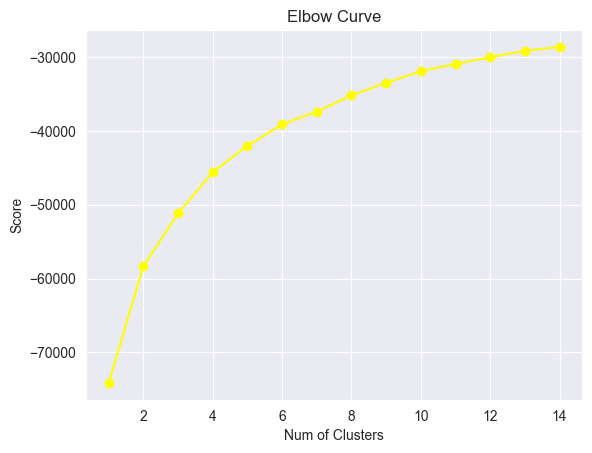

In [91]:
# Show kmeans.
plt.plot(k_range, score, marker='o', color='yellow')
plt.xlabel('Num of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [92]:
optimal_k = 4

kmeans = KMeans(n_clusters=optimal_k)
kmeans.fit(df_numeric)
len(kmeans.labels_)

7412

In [93]:
df_clusters = df.copy()
df_clusters['cluster'] = kmeans.labels_
df_clusters.head()

,name,rating,genre,year,score,votes,director,writer,star,country,budget,gross,company,runtime,profit,cluster
0,The Shining,6,6,1980,8.4,927000,Stanley Kubrick,Stephen King,Jack Nicholson,52,19000000,46998772,Warner Bros.,146,27998772,3
1,The Blue Lagoon,6,1,1980,5.8,65000,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,53,4500000,58853106,Columbia Pictures,104,54353106,1
2,Star Wars: Episode V - The Empire Strikes Back,4,0,1980,8.7,1200000,Irvin Kershner,Leigh Brackett,Mark Hamill,53,18000000,538375067,Lucasfilm,124,520375067,2
3,Airplane!,4,4,1980,7.7,221000,Jim Abrahams,Jim Abrahams,Robert Hays,53,3500000,83453539,Paramount Pictures,88,79953539,1
4,Caddyshack,6,4,1980,7.3,108000,Harold Ramis,Brian Doyle-Murray,Chevy Chase,53,6000000,39846344,Orion Pictures,98,33846344,1


In [ ]:
plt.figure(figsize=(12,7))
axis = sns.barplot(
    x=np.arange(0,optimal_k,1), 
    y=df_clusters.groupby(['cluster']).count()['budget'].values
)
x=axis.set_xlabel('Cluster Number')
y=axis.set_ylabel('Number of movies')


In [ ]:
df_numeric = df_clusters.select_dtypes(include=[np.number])
df_numeric = df_numeric.groupby('cluster').mean().round(2)

for cluster, count in df_clusters['cluster'].value_counts().sort_index().items():
    print(f'Cluster #{cluster} size: {count}')
    
df_numeric

Можно увидеть следующие группы:
- №0 и №2: Два наибольших кластера - большинство хороших фильмов. Первые выделяются хорошими прибылями profit
- №1: Небольшой кластер - фильмы с малыми прибылями
- №3: Наименьший кластер - фильмы с наибольшими финансовыми показателями

Посмотрим на представителей каждой группы.

In [ ]:
# Cluster 0.
df_view = df_clusters.drop(columns=['rating', 'genre', 'country', 'budget', 'gross'])
df_view[df_view['cluster'] == 0].sample(5)

In [ ]:
# Cluster 1.
df_view[df_view['cluster'] == 1].sample(5)

In [ ]:
# Cluster 2.
df_view[df_view['cluster'] == 2].sample(5)

In [ ]:
# Cluster 3.
df_view[df_view['cluster'] == 3].sample(5)

Действительно, можно наблюдать группу самых удачных прокатов, группу самых неудачных и две посередине. Разница между последними двумя в среднем порядке доходов (разница в десяток)